In [2]:
import json
import io

import pytest
from mapshader import core
from mapshader import sources

import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
import spatialpandas

from datashader.transfer_functions import Image

from mapshader.mercator import MercatorTileDefinition
from mapshader.sources import (
    MapSource,
    elevation_source,
    world_boundaries_source,
    world_cities_source,
)
from mapshader.core import (
    create_agg,
    shade_agg,
    FUNCTIONS_MAP,
    load_geojson,
    load_sources,
    point_aggregation,
    render_geojson,
    render_graph,
    render_map,
    to_raster,
)
from mapshader.tests.data import DEFAULT_SOURCES_FUNCS

In [2]:
import importlib
importlib.reload(core)
importlib.reload(sources)

/home/renato/.pyenv/versions/3.8.5/envs/mapshader/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<module 'mapshader.sources' from '/home/renato/Projects/makepath/mapshader/mapshader/sources.py'>

In [183]:
source = MapSource.from_obj(world_cities_source())
source.load()
geojson_string = render_geojson(source)

Using Given Filepath unmodified: config{self.config_file}
# ----------------------
# APPLYING TRANSFORMS World Cities
# ----------------------
	Applying reproject_vector
	Applying add_xy_fields
	Applying to_spatialpandas


/home/renato/.pyenv/versions/3.8.5/envs/mapshader/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
with open('../mapshader/tests/fixtures/bucees_stores_reversed_coords.json') as file:
    geojson_string = file.read()
reproject_transform = dict(name='reproject_vector', args=dict(epsg=3857))
add_xy_fields_transform = dict(name='add_xy_fields', args=dict(geometry_field='geometry'))
sp_transform = dict(name='to_spatialpandas', args=dict(geometry_field='geometry'))
transforms = [reproject_transform, ]

/home/renato/.pyenv/versions/3.8.5/envs/mapshader/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
graph = {
        'geojson_to_source_result': (
            'geojson_to_source',
            geojson_string,
            {
                'name': 'World Cities',
                 'key': 'world-cities',
                 'text': 'World Cities',
                 'description': 'World Cities Point Locations',
                 'geometry_type': 'point',
                 'agg_func': 'max',
                 'cmap': ['aqua', 'aqua'],
                 'shade_how': 'linear',
                 'dynspread': 2,
                 'raster_interpolate': 'linear',
                 'xfield': 'x',
                 'yfield': 'y',
                 'transforms': transforms,
            },
        ),
        'split_geometry_result': ('split_geometry', 'geojson_to_source_result'),
        'create_agg_result': (
            'create_agg',
            'split_geometry_result', 
            -10918095.097995743,
             3326103.8447637814,
             -9028079.164821325,
             3967812.0179502456,
        ),
        'shade_agg_result': (
            'shade_agg',
            'split_geometry_result', 'create_agg_result',
            -10918095.097995743,
             3326103.8447637814,
             -9028079.164821325,
             3967812.0179502456,
        ),
    }

In [43]:
data = render_graph(graph, 'shade_agg_result')

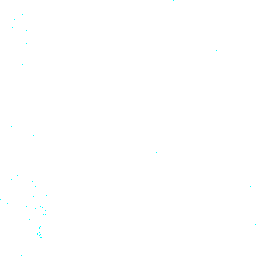

In [44]:
data

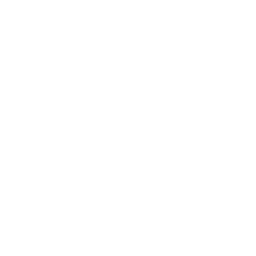

In [20]:
shade_agg(source, data, 120, 212, 9)

/home/renato/.pyenv/versions/3.8.5/envs/mapshader/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Shade without Span


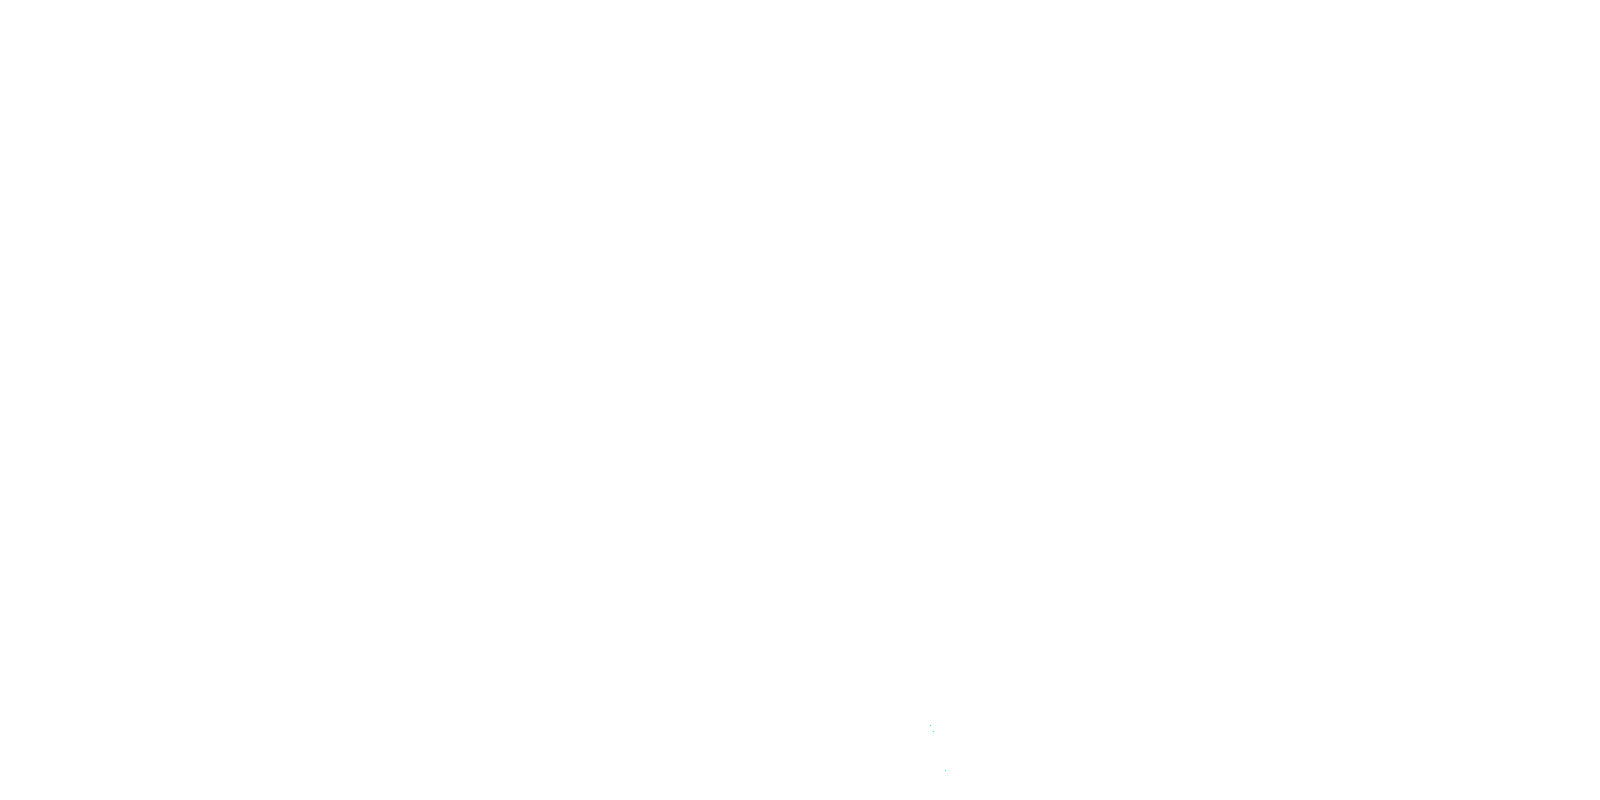

In [47]:
dataarray = create_agg(
    source, -20e6, -20e6, 20e6, 20e6,
    height=800, width=1600
)
shade_agg(
    source, dataarray, -20e6, -20e6, 20e6, 20e6,
)

In [272]:
data = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [248]:
data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [273]:
data

,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Luxembourg,POINT (6.13000 49.61166)
4,Palikir,POINT (158.14997 6.91664)
...,...,...
197,Cairo,POINT (31.24802 30.05191)
198,Tokyo,POINT (139.74946 35.68696)
199,Paris,POINT (2.33139 48.86864)
200,Santiago,POINT (-70.66899 -33.44807)


In [25]:
with open('../mapshader/tests/fixtures/bucees_stores.json') as file:
    geojson_string = file.read()
bucees = json.loads(geojson_string)
for feat in bucees['features']:
    feat['geometry']['coordinates'] = [
        float(feat['geometry']['coordinates'][1]),
        float(feat['geometry']['coordinates'][0]),
    ]
with open('../mapshader/tests/fixtures/bucees_stores_reversed_coords.json', 'w') as file:
    file.write(json.dumps(bucees))

/home/renato/.pyenv/versions/3.8.5/envs/mapshader/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
obj = world_cities_source()

In [23]:
source_default = MapSource.from_obj(obj)

In [24]:
source_default.load()

Using Given Filepath unmodified: config{self.config_file}
# ----------------------
# APPLYING TRANSFORMS World Cities
# ----------------------
	Applying reproject_vector
	Applying add_xy_fields
	Applying to_spatialpandas


In [25]:
source_default.data

/home/renato/.pyenv/versions/3.8.5/envs/mapshader/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,name,geometry,X,Y
0,Vatican City,"Point([1386304.6488380614, 5146502.575862345])",1.386305e+06,5.146503e+06
1,San Marino,"Point([1385011.5185332587, 5455558.186449198])",1.385012e+06,5.455558e+06
2,Vaduz,"Point([1059390.7997719282, 5963928.576226929])",1.059391e+06,5.963929e+06
3,Luxembourg,"Point([682388.790950537, 6379291.915456844])",6.823888e+05,6.379292e+06
4,Palikir,"Point([17605174.610690508, 771834.1794486978])",1.760517e+07,7.718342e+05
...,...,...,...,...
197,Cairo,"Point([3478513.9375373856, 3510223.6485976437])",3.478514e+06,3.510224e+06
198,Tokyo,"Point([15556838.900667187, 4257632.982114632])",1.555684e+07,4.257633e+06
199,Paris,"Point([259529.08832175197, 6252601.467208495])",2.595291e+05,6.252601e+06
200,Santiago,"Point([-7866835.615787239, -3954929.633151686])",-7.866836e+06,-3.954930e+06


In [29]:
type(source_default.data)

/home/renato/.pyenv/versions/3.8.5/envs/mapshader/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


spatialpandas.geodataframe.GeoDataFrame

In [30]:
type(source_default)

mapshader.sources.VectorSource

In [31]:
source_default.geometry_field

'geometry'

In [39]:
spatialpandas.GeoDataFrame(source.data, geometry=source.geometry_field)

,geometry,X,Y
0,"Point([29.040639, -95.413212])",29.040639,-95.413212
1,"Point([29.063866, -95.427278])",29.063866,-95.427278
2,"Point([29.055565, -95.571861])",29.055565,-95.571861
3,"Point([29.034737, -95.567102])",29.034737,-95.567102
4,"Point([28.980863, -95.337008])",28.980863,-95.337008
5,"Point([28.969488, -95.369951])",28.969488,-95.369951
6,"Point([28.610024, -96.648904])",28.610024,-96.648904
7,"Point([29.184814, -95.408825])",29.184814,-95.408825
8,"Point([29.430206, -95.226369])",29.430206,-95.226369
9,"Point([30.179754, -96.913816])",30.179754,-96.913816


In [41]:
geodf = gpd.read_file('../mapshader/tests/fixtures/bucees_stores_reversed_coords.json')
geodf = geodf.to_crs(epsg=3857)
(
geodf['geometry'].x.min(),
geodf['geometry'].y.min(),
geodf['geometry'].x.max(),
geodf['geometry'].y.max(),)

(-10918095.097995743,
 3326103.8447637814,
 -9028079.164821325,
 3967812.0179502456)

In [25]:
gpd.read_file(io.StringIO(geojson_string)).crs

/home/renato/.pyenv/versions/3.8.5/envs/mapshader/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
new_src = MapSource.from_geojson(geojson_string, {
                'name': 'World Cities',
                 'key': 'world-cities',
                 'text': 'World Cities',
                 'description': 'World Cities Point Locations',
                 'geometry_type': 'point',
                 'agg_func': 'max',
                 'cmap': ['aqua', 'aqua'],
                 'shade_how': 'linear',
                 'dynspread': 2,
                 'raster_interpolate': 'linear',
                 'xfield': 'X',
                 'yfield': 'Y',
                 'transforms': transforms,
            })


/home/renato/.pyenv/versions/3.8.5/envs/mapshader/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
new_src.data.to_crs(epsg=3857)

,hasEthanolFree,octaneLevel,hours,address,id,city,zip,title,country,state,hasDefAtPump,hasCarWash,store,geometry
0,True,92 Octane,"<table role=""presentation"" class=""wpsl-opening...",899 Oyster Creek Drive,203,Lake Jackson,77566,"#1 - Texas, Lake Jackson, 899 Oyster Creek Drive",United States,Texas,False,False,#1,POINT (inf inf)
1,False,,"<table role=""presentation"" class=""wpsl-opening...",101 N Hwy 2004,204,Lake Jackson,77566,"#2 - Texas, Lake Jackson, 101 N Hwy 2004",United States,Texas,False,False,#2,POINT (inf inf)
2,True,92 Octane,"<table role=""presentation"" class=""wpsl-opening...",801 N Brooks,205,Brazoria,77422,"#3 - Texas, Brazoria, 801 N Brooks",United States,Texas,False,False,#3,POINT (inf inf)
3,False,,"<table role=""presentation"" class=""wpsl-opening...",1101 S Brooks,206,Brazoria,77422,"#5 - Texas, Brazoria, 1101 S Brooks",United States,Texas,False,False,#5,POINT (inf inf)
4,False,,"<table role=""presentation"" class=""wpsl-opening...",4231 E. Hwy 332,207,Freeport,77541,"#7 - Texas, Freeport, 4231 E. Hwy 332",United States,Texas,False,False,#7,POINT (inf inf)
5,False,,"<table role=""presentation"" class=""wpsl-opening...",1002 N Brazosport Blvd.,208,Freeport,77541,"#8 - Texas, Freeport, 1002 N Brazosport Blvd.",United States,Texas,False,False,#8,POINT (inf inf)
6,False,,"<table role=""presentation"" class=""wpsl-opening...",2318 W Main,209,Port Lavaca,77979,"#12 - Texas, Port Lavaca, 2318 W Main",United States,Texas,False,False,#12,POINT (inf inf)
7,False,,"<table role=""presentation"" class=""wpsl-opening...",2299 E Mulberry St,210,Angleton,77515,"#13 - Texas, Angleton, 2299 E Mulberry St",United States,Texas,False,False,#13,POINT (inf inf)
8,False,,"<table role=""presentation"" class=""wpsl-opening...",780 Hwy-35 N Byp,211,Alvin,77511,"#14 - Texas, Alvin, 780 Hwy-35 N Byp",United States,Texas,False,False,#14,POINT (inf inf)
9,False,,"<table role=""presentation"" class=""wpsl-opening...",2375 E Austin St,212,Giddings,78942,"#16 - Texas, Giddings, 2375 E Austin St",United States,Texas,False,False,#16,POINT (inf inf)


In [11]:
new_src.load()

# ----------------------
# APPLYING TRANSFORMS World Cities
# ----------------------
	Applying reproject_vector


In [12]:
new_src.data.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
new_src.data

/home/renato/.pyenv/versions/3.8.5/envs/mapshader/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,geometry
0,POINT (inf inf)
1,POINT (inf inf)
2,POINT (inf inf)
3,POINT (inf inf)
4,POINT (inf inf)
5,POINT (inf inf)
6,POINT (inf inf)
7,POINT (inf inf)
8,POINT (inf inf)
9,POINT (inf inf)
